In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


import re
import string
import librosa
import librosa.display
import IPython.display as ipd
import torch

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
df_train = pd.read_csv("train.csv")

In [6]:
df_train.shape

(6324, 88201)

In [3]:
df_test = pd.read_csv("test.csv")

In [4]:
df_test.shape

(999, 88201)

In [21]:
# downsample by taking every 100th entry
small = df_train[::100]
tiny = small[:1]

In [79]:
train = small.values

In [82]:
N_train = train.shape[0]
NUM_SAMPLES = train.shape[1]-1

print (N_train, NUM_SAMPLES)

X_train = train[:,:-1]
y_train = train[:,-1]
y_train = y_train.reshape(N_train,1)

64 88200


In [87]:
X_train[0]

array([ 0.        ,  0.00071228,  0.00142399, ..., -0.00213454,
       -0.00142399, -0.00071228])

In [59]:
SAMPLE_RATE = 22050

In [43]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [44]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [65]:
spec = mel_spec(signal[0])

/Users/kevinlee/anaconda/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [67]:
FEATS, FRAMES = spec.shape

In [88]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = mel_spec(X_train[i])

/Users/kevinlee/anaconda/lib/python3.6/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


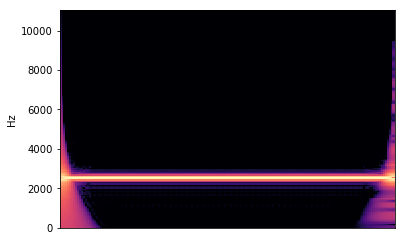

In [116]:
librosa.display.specshow(tmp_train[0], y_axis='hz')

In [119]:
ipd.Audio(X_train[5], rate=SAMPLE_RATE)

Ideas:
* make a function called "extract_features"
* Mel-frequency cepstral coefficients (MFCCs) possibly useful feature: librosa.feature.mfcc, librosa.feature.chroma_stft, librosa.feature.spectral_contrast, librosa.feature.tonnetz
* convolutions with different types of filters -- try some, maybe denoise
* another approach: kernel regression with wasserstein distance between spectra?
